In [2]:
import os
import pandas as pd
import yaml

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

SOL_ROOT = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint'
SCALES_PATH = '/home/ddon0001/PhD/data/cell_tracking_challenge/scales.yaml'

ds_summary = pd.read_csv(f'{SOL_ROOT}/summary.csv')
with open(SCALES_PATH, 'r') as f:
    scales = yaml.safe_load(f)

all_info_df = pd.read_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'))
all_divisions = all_info_df[all_info_df.is_parent]
columns_of_interest = [
    'node_area',
    'child_distance_difference',
    'child_distance_sum',
    'interchild_distance',
    'div_angle',
    'div_valid',
    'neighbour_rank_sum',
    'neighbour_rank_difference',
    'child_area_prop',
    'div_correct'
]

In [16]:
ds_names = []
n_sampled = []
n_false_sampled = []
n_true_sampled = []
pred_accuracy = []

for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']

    ds_divisions = all_divisions[all_divisions.ds_name == ds_name]
    if len(ds_divisions) <= 15:
        continue

    ds_divisions['sampled'] = 0
    while ds_divisions['sampled'].sum() < len(ds_divisions):
        still_to_sample = ds_divisions[ds_divisions['sampled'] == 0]
        if len(still_to_sample) >= 10:
            n = 10
        else:
            n = len(still_to_sample)
        new_sample = still_to_sample.sample(n=n)
        ds_divisions.loc[new_sample.index, 'sampled'] = 1

        all_sampled = ds_divisions[ds_divisions['sampled'] == 1][columns_of_interest]

        X = all_sampled.drop(columns=['div_correct'])
        y = all_sampled.div_correct
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        count_true = y_train.sum()
        count_false = len(y_train) - count_true

        rf = RandomForestClassifier()
        param_dist = {
            # number of trees
            'n_estimators': randint(2,200),
            # depth of the tree
            'max_depth': randint(1,20)
        }

        # searching for best hyperparameters using randomized search
        search = RandomizedSearchCV(
            rf,
            param_distributions = param_dist,
            n_iter = 5,
            cv = 5 if (count_true >= 5 and count_false >= 5) else 2,
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        truth = ds_divisions['div_correct']
        predictions = best_model.predict(ds_divisions[columns_of_interest].drop(columns=['div_correct']))
        accuracy = accuracy_score(truth, predictions)
        ds_names.append(ds_name)
        n_sampled.append(len(all_sampled))
        n_false_sampled.append(len(all_sampled) - all_sampled.div_correct.sum())
        n_true_sampled.append(all_sampled.div_correct.sum())
        pred_accuracy.append(accuracy)

/tmp/ipykernel_30588/380024636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_divisions['sampled'] = 0
/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/tmp/ipykernel_30588/380024636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_divisions['sampled'] = 0
/tmp/ipykernel_30588/380024636.py:14: SettingWithCopyWarning: 
A value 

<Axes: xlabel='n_sampled', ylabel='pred_accuracy'>

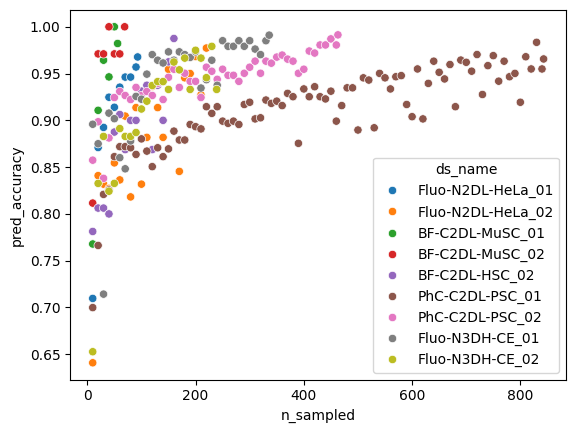

In [17]:
import seaborn as sns
it_df = pd.DataFrame({
    'ds_name': ds_names,
    'n_sampled': n_sampled,
    'n_false_sampled': n_false_sampled,
    'n_true_sampled': n_true_sampled,
    'pred_accuracy': pred_accuracy
})

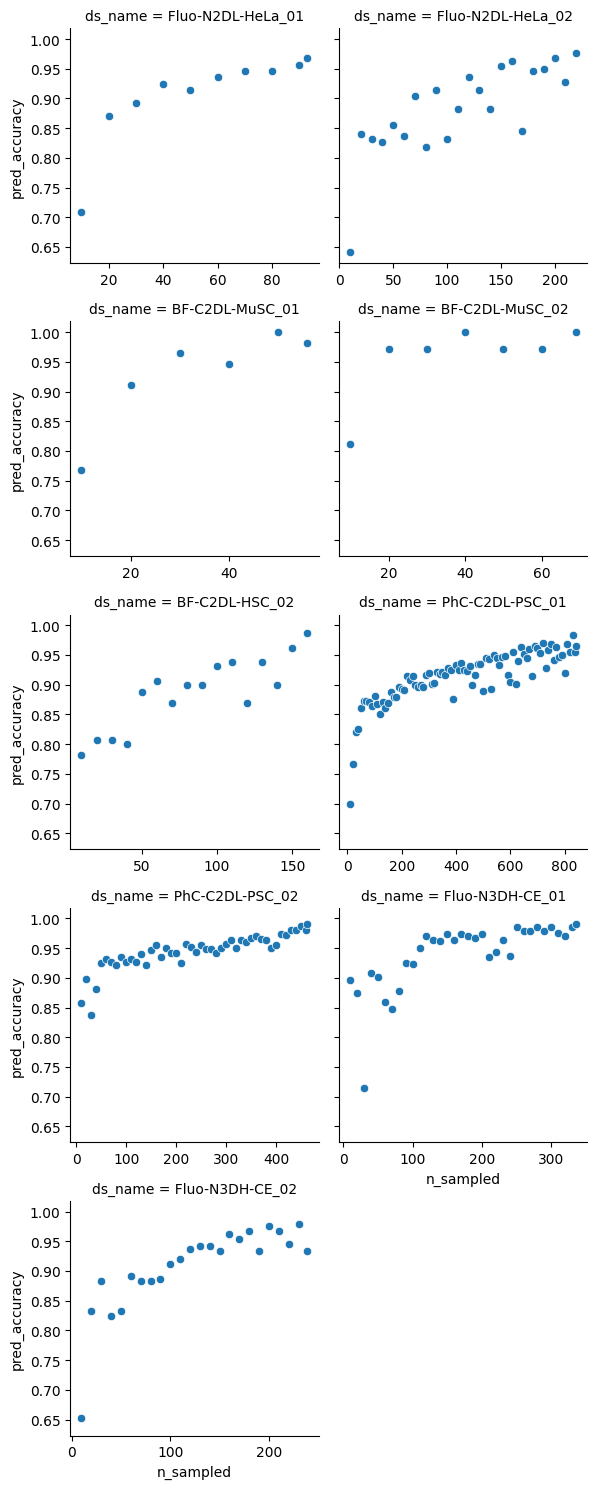

In [18]:
import seaborn as sns

grid = sns.FacetGrid(it_df, col='ds_name', col_wrap=2, sharex=False, sharey=True, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='n_sampled', y='pred_accuracy')
grid.add_legend()